In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

Key Points Using Holistic

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_styled_landmarks(image, results):
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=1, circle_radius=3), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=1, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=1, circle_radius=3), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=1, circle_radius=1)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=1, circle_radius=3), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=1, circle_radius=1)
                             ) 

Extract Keypoint Values

In [5]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, lh, rh])

Setup Folders for Collection

In [6]:
path = os.getcwd()
DATA_PATH = os.path.join('Dataset') 

# Action Lists
actions = np.array(['halo', 'apa kabar', 'aku', 'kamu', 'maaf', 'tolong', 'ya', 'tidak', 'suka', 'makanan', 
                    'selamat pagi', 'selamat siang', 'selamat sore', 'selamat malam', 'sampai jumpa lagi', 
                    'perkenalkan', 'terima kasih', 'sama-sama', 'mau', 'tidak mau'])

# num videos worth of data
no_sequences = 40

# Videos are going to be num frames in length
sequence_length = 30

## Preprocess Data and Create Labels and Features

In [7]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

### Mapping Label

In [8]:
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'halo': 0,
 'apa kabar': 1,
 'aku': 2,
 'kamu': 3,
 'maaf': 4,
 'tolong': 5,
 'ya': 6,
 'tidak': 7,
 'suka': 8,
 'makanan': 9,
 'selamat pagi': 10,
 'selamat siang': 11,
 'selamat sore': 12,
 'selamat malam': 13,
 'sampai jumpa lagi': 14,
 'perkenalkan': 15,
 'terima kasih': 16,
 'sama-sama': 17,
 'mau': 18,
 'tidak mau': 19}

### Prepocessing Normal Sequence

In [28]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [29]:
np.array(sequences).shape

(800, 30, 258)

In [30]:
np.array(labels).shape

(800,)

In [31]:
X = np.array(sequences)
X.shape

(800, 30, 258)

In [ ]:
y = to_categorical(labels, num_classes=len(actions))  # Shape: (num_frames, num_classes)
y.shape

(800, 20)

### Preprocessing Windowed Sequence

In [14]:
WINDOW_SIZE = 10  # Number of frames in each input window
STRIDE = 5  # Shift of the window

X = []  # Store sequences
y = []  # Store labels

for action in actions:  # Iterate through action labels
    action_path = os.path.join(DATA_PATH, action)
    
    for iteration in os.listdir(action_path):
        iteration_path = os.path.join(action_path, iteration)
        frames = []
        
        for frame_file in sorted(os.listdir(iteration_path)):  # Ensure correct order
            frame_path = os.path.join(iteration_path, frame_file)
            frame_data = np.load(frame_path)  # Shape (258,)
            frames.append(frame_data)
        
        # Apply sliding window
        num_frames = len(frames)
        for start in range(0, num_frames - WINDOW_SIZE + 1, STRIDE):
            window = frames[start:start + WINDOW_SIZE]  # Extract window
            X.append(window)  # Shape: (WINDOW_SIZE, 258)
            y.append(label_map[action])  # Map action label to number

X = np.array(X)  # Shape: (num_windows, WINDOW_SIZE, 258)
y = np.array(y)  # Shape: (num_windows,)

In [15]:
X.shape

(4000, 10, 258)

In [16]:
y.shape

(4000,)

In [17]:
y = to_categorical(y, num_classes=len(actions))  # Shape: (num_windows, num_classes)
y.shape

(4000, 20)

### Train Test Split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [19]:
print("X_train.shape: ", X_train.shape) # (num_windows, WINDOW_SIZE, 258)
print("y_train.shape: ", y_train.shape) # (num_windows, num_classes)

X_train.shape:  (3200, 10, 258)
y_train.shape:  (3200, 20)


## Build and Train LSTM Neural Network

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard

### Model for Normal Sequence

In [172]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,258)))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

### Model for Windowed Sequece

#### 1st Architecture

In [21]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(10, 258)))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False, activation='relu')) 
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(actions), activation='softmax'))

In [ ]:
# model = Sequential()
# model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(10, 258)))
# model.add(Dropout(0.2))  # Dropout inside LSTM
# model.add(BatchNormalization())

# model.add(LSTM(64, return_sequences=True, activation='relu'))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())

# model.add(LSTM(32, return_sequences=False, activation='relu'))  # Smaller last LSTM layer
# model.add(Dropout(0.3))  # Increase dropout before Dense layers

# model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(len(actions), activation='softmax'))

In [22]:
# model.compile(optimizer='Adam)', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy', 
              metrics=['categorical_accuracy'])

In [23]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),  # Use validation set for monitoring
    epochs=300,  
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/300


100/100 [==============================] - 23s 66ms/step - loss: 2.8350 - categorical_accuracy: 0.1138 - val_loss: 2.7349 - val_categorical_accuracy: 0.2313 - lr: 0.0010
Epoch 2/300
100/100 [==============================] - 4s 39ms/step - loss: 2.2414 - categorical_accuracy: 0.2391 - val_loss: 2.0064 - val_categorical_accuracy: 0.3688 - lr: 0.0010
Epoch 3/300
100/100 [==============================] - 4s 37ms/step - loss: 1.6691 - categorical_accuracy: 0.4053 - val_loss: 1.4021 - val_categorical_accuracy: 0.4787 - lr: 0.0010
Epoch 4/300
100/100 [==============================] - 4s 37ms/step - loss: 1.2927 - categorical_accuracy: 0.5247 - val_loss: 0.8370 - val_categorical_accuracy: 0.7138 - lr: 0.0010
Epoch 5/300
100/100 [==============================] - 4s 36ms/step - loss: 1.0610 - categorical_accuracy: 0.6122 - val_loss: 0.7993 - val_categorical_accuracy: 0.6837 - lr: 0.0010
Epoch 6/300
100/100 [==============================] - 4s 38ms/step - loss: 0.9202 - categor

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 64)            82688     
                                                                 
 dropout (Dropout)           (None, 10, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 64)            33024     
                                                                 
 dropout_1 (Dropout)         (None, 10, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 batch_normalization (Batch  (None, 32)                1

Make Predictions

In [25]:
res = model.predict(X_test)

25/25 [==============================] - 3s 22ms/step


In [26]:
actions[np.argmax(res[1])]

'selamat malam'

In [27]:
actions[np.argmax(y_test[1])]

'selamat malam'

Save Model

In [33]:
model.save('Models/model_windowed_seq_1.h5')

d:\python\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.load_weights('Models/model_windowed_seq_1.h5')

Convert model to jason

Evaluation using Confusion Matrix and Accuracy

In [28]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [29]:
yhat = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

multilabel_confusion_matrix(ytrue, yhat)

25/25 [==============================] - 1s 22ms/step


array([[[760,   0],
        [  1,  39]],

       [[758,   2],
        [  0,  40]],

       [[760,   0],
        [  0,  40]],

       [[760,   0],
        [  0,  40]],

       [[760,   0],
        [  1,  39]],

       [[760,   0],
        [  0,  40]],

       [[759,   1],
        [  0,  40]],

       [[759,   1],
        [  0,  40]],

       [[760,   0],
        [  0,  40]],

       [[760,   0],
        [  0,  40]],

       [[755,   5],
        [  4,  36]],

       [[746,  14],
        [  1,  39]],

       [[759,   1],
        [ 13,  27]],

       [[756,   4],
        [  5,  35]],

       [[759,   1],
        [  0,  40]],

       [[760,   0],
        [  2,  38]],

       [[760,   0],
        [  2,  38]],

       [[760,   0],
        [  0,  40]],

       [[760,   0],
        [  0,  40]],

       [[760,   0],
        [  0,  40]]], dtype=int64)

In [30]:
accuracy_score(ytrue, yhat)

0.96375

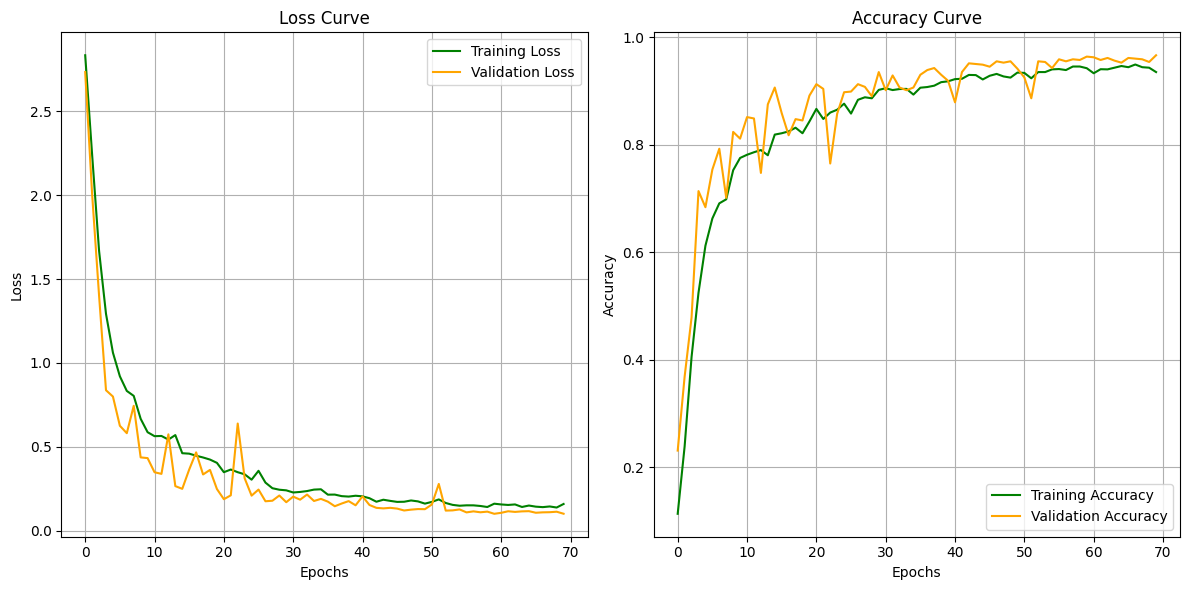

In [31]:
# Plot training loss and training accuracy
plt.figure(figsize=(12, 6))

# Plotting training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)

# Plotting training accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.grid(True)

# Plotting validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)

# Plotting Validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

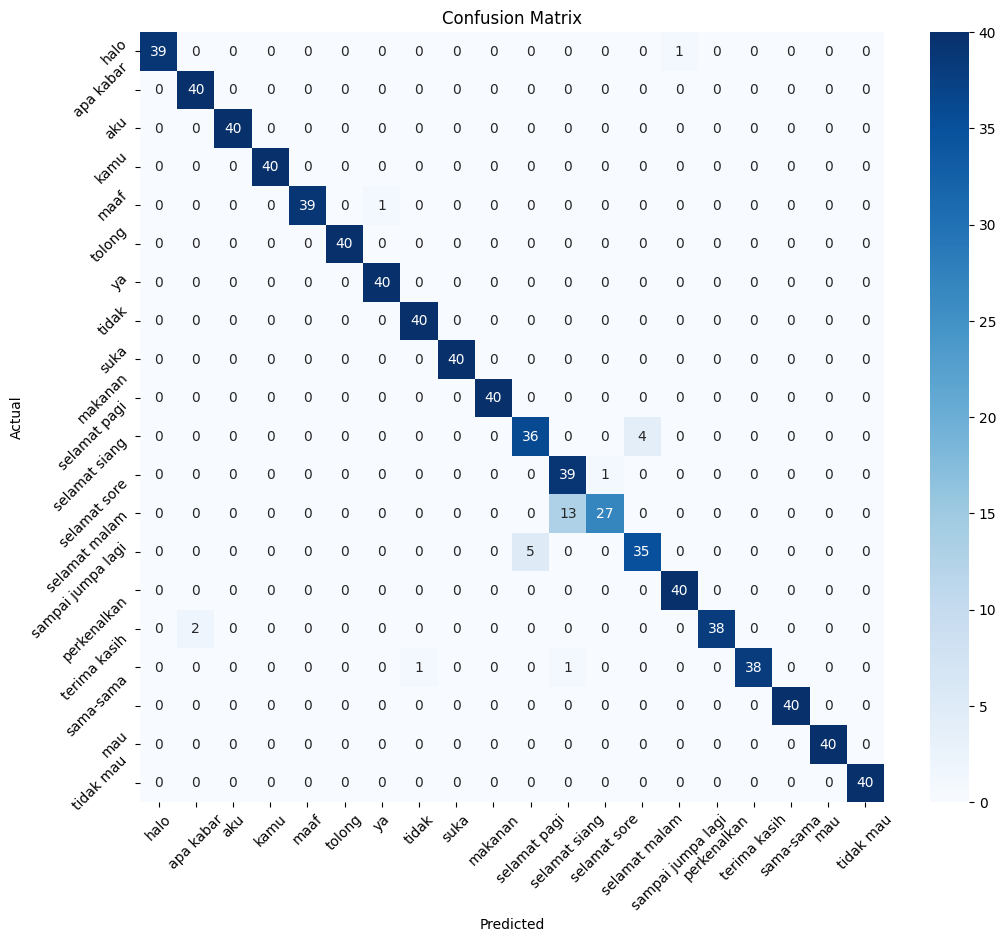


Precision: 0.9677414834743413
Recall: 0.96375
F1 Score: 0.9634883187408214

Classification Report:
                    precision    recall  f1-score   support

             halo       1.00      0.97      0.99        40
        apa kabar       0.95      1.00      0.98        40
              aku       1.00      1.00      1.00        40
             kamu       1.00      1.00      1.00        40
             maaf       1.00      0.97      0.99        40
           tolong       1.00      1.00      1.00        40
               ya       0.98      1.00      0.99        40
            tidak       0.98      1.00      0.99        40
             suka       1.00      1.00      1.00        40
          makanan       1.00      1.00      1.00        40
     selamat pagi       0.88      0.90      0.89        40
    selamat siang       0.74      0.97      0.84        40
     selamat sore       0.96      0.68      0.79        40
    selamat malam       0.90      0.88      0.89        40
sampai jumpa 

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report

# Convert predictions & labels to integer class indices
y_true = np.argmax(y_test, axis=1).tolist()
y_pred = np.argmax(res, axis=1).tolist()

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define class labels for the heatmap
class_labels = list(label_map.keys())  # Get sign language action labels

# Plot Confusion Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

# Precision, Recall, F1-Score, and accuration
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

print("\nPrecision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Detailed classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))